# Test V4 Models with Correct Embedding Architecture

This notebook tests the new V4 models that use the correct latent_dim=8 embedding architecture like the original VampNet.

In [1]:
import numpy as np
import torch
import onnxruntime as ort
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path
import sys
sys.path.append('../')

from vampnet_onnx.sampling import temperature_sample, top_p_sample

print("Libraries loaded successfully!")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded successfully!


## Load V4 Models

In [2]:
# Load ONNX models
encoder_path = "../scripts/models/vampnet_encoder_prepadded.onnx"
decoder_path = "../scripts/models/vampnet_codec_decoder.onnx"
coarse_v4_path = "../onnx_models_fixed/coarse_v4_correct.onnx"
c2f_v4_path = "../onnx_models_fixed/c2f_v4_correct.onnx"

# Create sessions
encoder_session = ort.InferenceSession(encoder_path)
decoder_session = ort.InferenceSession(decoder_path)
coarse_v4_session = ort.InferenceSession(coarse_v4_path)
c2f_v4_session = ort.InferenceSession(c2f_v4_path)

print("V4 models loaded successfully!")
print(f"Coarse V4: {coarse_v4_path}")
print(f"C2F V4: {c2f_v4_path}")

V4 models loaded successfully!
Coarse V4: ../onnx_models_fixed/coarse_v4_correct.onnx
C2F V4: ../onnx_models_fixed/c2f_v4_correct.onnx


## Helper Functions

In [3]:
def encode_audio(audio, sample_rate=44100):
    """Encode audio to tokens using the encoder."""
    # Resample to 44.1kHz if needed
    if sample_rate != 44100:
        import resampy
        audio = resampy.resample(audio, sample_rate, 44100)
    
    # Normalize and prepare
    audio = audio / (np.abs(audio).max() + 1e-8)
    audio = audio.astype(np.float32)
    
    # Pad to multiple of 768
    pad_length = (768 - len(audio) % 768) % 768
    if pad_length > 0:
        audio = np.pad(audio, (0, pad_length), mode='constant')
    
    # Add batch dimension
    audio_batch = audio[np.newaxis, np.newaxis, :]
    
    # Encode - use correct input name 'audio_padded'
    tokens = encoder_session.run(None, {'audio_padded': audio_batch})[0]
    
    return tokens


def decode_tokens(tokens):
    """Decode tokens back to audio."""
    # Ensure int64
    tokens = tokens.astype(np.int64)
    
    # Clamp tokens to valid range [0, 1023] for decoder
    tokens = np.clip(tokens, 0, 1023)
    
    # Decode
    audio = decoder_session.run(None, {'codes': tokens})[0]
    
    # Remove batch dimension
    audio = audio[0, 0]
    
    return audio


def generate_with_v4_model(tokens, mask, session, temperature=1.0, top_p=0.9):
    """Generate tokens using V4 model with sampling."""
    # Get logits from model
    logits = session.run(None, {
        'codes': tokens.astype(np.int64),
        'mask': mask
    })[0]
    
    # Sample from logits
    batch_size, n_codebooks, seq_len, vocab_size = logits.shape
    sampled_tokens = np.zeros_like(tokens)
    
    for b in range(batch_size):
        for c in range(n_codebooks):
            for t in range(seq_len):
                if mask[b, c, t]:
                    # Apply temperature
                    probs = temperature_sample(logits[b, c, t], temperature)
                    # Apply top-p
                    probs = top_p_sample(probs, top_p)
                    # Sample - note we exclude the last token (1024) which is the mask token
                    sampled_tokens[b, c, t] = np.random.choice(len(probs) - 1, p=probs[:-1] / probs[:-1].sum())
                else:
                    sampled_tokens[b, c, t] = tokens[b, c, t]
    
    return sampled_tokens

## Test with Audio

In [4]:
# Load test audio
audio_path = "../tests/test_data/short_audio.wav"
if not Path(audio_path).exists():
    # Generate test audio if it doesn't exist
    import subprocess
    subprocess.run([sys.executable, "../tests/test_data/test_audio.py"])

audio, sr = sf.read(audio_path)
if audio.ndim > 1:
    audio = audio.mean(axis=1)

# Calculate how much audio corresponds to 100 tokens
# Each token represents 768/44100 = ~0.0174 seconds at 44.1kHz
# 100 tokens = ~1.74 seconds
max_duration = 100 * 768 / 44100
print(f"Note: Models work with exactly 100 tokens, which is ~{max_duration:.2f} seconds of audio")

# Take appropriate segment
audio = audio[:int(sr * max_duration)]

print(f"Loaded audio: {len(audio)/sr:.2f} seconds at {sr} Hz")
ipd.display(ipd.Audio(audio, rate=sr))

Note: Models work with exactly 100 tokens, which is ~1.74 seconds of audio
Loaded audio: 1.74 seconds at 44100 Hz


In [5]:
# Encode audio
tokens = encode_audio(audio, sr)
print(f"Encoded tokens shape: {tokens.shape}")
print(f"Token range: [{tokens.min()}, {tokens.max()}]")

# IMPORTANT: Models expect exactly 100 tokens
if tokens.shape[2] > 100:
    print(f"Truncating tokens from {tokens.shape[2]} to 100")
    tokens = tokens[:, :, :100]
elif tokens.shape[2] < 100:
    print(f"Padding tokens from {tokens.shape[2]} to 100")
    pad_length = 100 - tokens.shape[2]
    tokens = np.pad(tokens, ((0, 0), (0, 0), (0, pad_length)), mode='constant', constant_values=0)

print(f"Final tokens shape: {tokens.shape}")

# Decode original tokens
reconstructed = decode_tokens(tokens)
print(f"\nReconstructed audio shape: {reconstructed.shape}")
ipd.display(ipd.Audio(reconstructed, rate=44100))

Encoded tokens shape: (1, 14, 100)
Token range: [0, 1022]
Final tokens shape: (1, 14, 100)

Reconstructed audio shape: (76800,)


## Test V4 Coarse Model

In [6]:
# Create mask for middle portion
mask = np.zeros_like(tokens, dtype=bool)
seq_len = 100  # Fixed sequence length
mask_start = seq_len // 3  # 33
mask_end = 2 * seq_len // 3  # 66
mask[:, :, mask_start:mask_end] = True

print(f"Using fixed sequence length: {seq_len}")
print(f"Masking tokens from {mask_start} to {mask_end}")
print(f"Number of masked tokens: {mask_end - mask_start}")

# Store original for comparison
original_masked_tokens = tokens[:, :4, mask_start:mask_end].copy()

# Generate with V4 coarse model
generated_coarse = generate_with_v4_model(
    tokens[:, :4, :],  # Only first 4 codebooks for coarse
    mask[:, :4, :],
    coarse_v4_session,
    temperature=1.0,
    top_p=0.9
)

print(f"Generated coarse tokens shape: {generated_coarse.shape}")

# Check if tokens actually changed
generated_masked_tokens = generated_coarse[:, :, mask_start:mask_end]
tokens_changed = np.sum(original_masked_tokens != generated_masked_tokens)
total_masked = np.sum(mask[:, :4, :])

print(f"\nDebug info:")
print(f"Original masked tokens mean: {original_masked_tokens.mean():.2f}")
print(f"Generated masked tokens mean: {generated_masked_tokens.mean():.2f}")
print(f"Tokens changed: {tokens_changed} out of {total_masked} masked positions ({tokens_changed/total_masked*100:.1f}%)")

Using fixed sequence length: 100
Masking tokens from 33 to 66
Number of masked tokens: 33
Generated coarse tokens shape: (1, 4, 100)

Debug info:
Original masked tokens mean: 381.30
Generated masked tokens mean: 500.31
Tokens changed: 131 out of 132 masked positions (99.2%)


In [7]:
# Prepare for C2F
seq_len = 100  # Fixed sequence length
c2f_input = np.zeros((1, 14, seq_len), dtype=np.int64)
c2f_input[:, :4, :] = generated_coarse

# Create C2F mask (only mask codebooks 4-13)
c2f_mask = np.zeros((1, 14, seq_len), dtype=bool)
c2f_mask[:, 4:, mask_start:mask_end] = True

print(f"C2F input shape: {c2f_input.shape}")
print(f"C2F mask shape: {c2f_mask.shape}")
print(f"Masked codebooks: 4-13")

# Generate with V4 C2F model
generated_c2f = generate_with_v4_model(
    c2f_input,
    c2f_mask,
    c2f_v4_session,
    temperature=0.8,
    top_p=0.95
)

print(f"Generated C2F tokens shape: {generated_c2f.shape}")

C2F input shape: (1, 14, 100)
C2F mask shape: (1, 14, 100)
Masked codebooks: 4-13
Generated C2F tokens shape: (1, 14, 100)


In [8]:
# Decode generated audio
generated_audio = decode_tokens(generated_c2f)
print(f"Generated audio shape: {generated_audio.shape}")

# Additional debugging
print("\nToken distribution analysis:")
print(f"Original tokens - Min: {tokens.min()}, Max: {tokens.max()}, Mean: {tokens.mean():.2f}, Std: {tokens.std():.2f}")
print(f"Generated coarse - Min: {generated_coarse.min()}, Max: {generated_coarse.max()}, Mean: {generated_coarse.mean():.2f}, Std: {generated_coarse.std():.2f}")
print(f"Generated C2F - Min: {generated_c2f.min()}, Max: {generated_c2f.max()}, Mean: {generated_c2f.mean():.2f}, Std: {generated_c2f.std():.2f}")

# Check for any tokens at the boundary (1023)
boundary_tokens = np.sum(generated_c2f == 1023)
print(f"\nTokens at boundary (1023): {boundary_tokens}")

# Display results
print("\nOriginal:")
ipd.display(ipd.Audio(reconstructed, rate=44100))

print("\nGenerated with V4 models (correct embedding architecture):")
ipd.display(ipd.Audio(generated_audio, rate=44100))

# Also create separate audio for just the masked region
mask_start_samples = mask_start * 768
mask_end_samples = mask_end * 768
print(f"\nMasked region only (samples {mask_start_samples} to {mask_end_samples}):")
print("Original masked region:")
ipd.display(ipd.Audio(reconstructed[mask_start_samples:mask_end_samples], rate=44100))
print("Generated masked region:")
ipd.display(ipd.Audio(generated_audio[mask_start_samples:mask_end_samples], rate=44100))

Generated audio shape: (76800,)

Token distribution analysis:
Original tokens - Min: 0, Max: 1022, Mean: 482.10, Std: 293.49
Generated coarse - Min: 17, Max: 1021, Mean: 479.69, Std: 260.17
Generated C2F - Min: 0, Max: 1021, Mean: 261.14, Std: 318.48

Tokens at boundary (1023): 0

Original:



Generated with V4 models (correct embedding architecture):



Masked region only (samples 25344 to 50688):
Original masked region:


Generated masked region:


## Compare Token Distributions

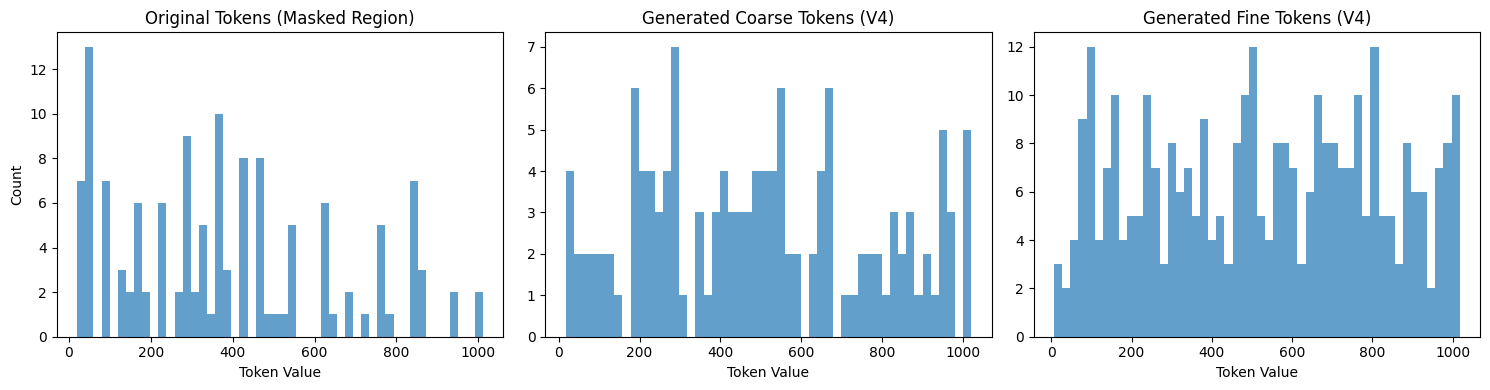

Token Statistics:
Original - Mean: 381.30, Std: 266.13
Coarse V4 - Mean: 500.31, Std: 282.72
Fine V4 - Mean: 526.41, Std: 285.55


In [9]:
# Compare token distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original tokens
axes[0].hist(tokens[:, :4, mask_start:mask_end].flatten(), bins=50, alpha=0.7)
axes[0].set_title("Original Tokens (Masked Region)")
axes[0].set_xlabel("Token Value")
axes[0].set_ylabel("Count")

# Generated coarse tokens
axes[1].hist(generated_coarse[:, :, mask_start:mask_end].flatten(), bins=50, alpha=0.7)
axes[1].set_title("Generated Coarse Tokens (V4)")
axes[1].set_xlabel("Token Value")

# Generated fine tokens
axes[2].hist(generated_c2f[:, 4:, mask_start:mask_end].flatten(), bins=50, alpha=0.7)
axes[2].set_title("Generated Fine Tokens (V4)")
axes[2].set_xlabel("Token Value")

plt.tight_layout()
plt.show()

# Statistics
print("Token Statistics:")
print(f"Original - Mean: {tokens[:, :4, mask_start:mask_end].mean():.2f}, Std: {tokens[:, :4, mask_start:mask_end].std():.2f}")
print(f"Coarse V4 - Mean: {generated_coarse[:, :, mask_start:mask_end].mean():.2f}, Std: {generated_coarse[:, :, mask_start:mask_end].std():.2f}")
print(f"Fine V4 - Mean: {generated_c2f[:, 4:, mask_start:mask_end].mean():.2f}, Std: {generated_c2f[:, 4:, mask_start:mask_end].std():.2f}")

## Test Different Sampling Parameters

## Test Iterative Refinement

VampNet often uses iterative refinement to improve quality. Let's test this approach.

In [10]:
# Test iterative refinement
print("Testing iterative refinement...")

# Start with original tokens
iter_tokens = tokens[:, :4, :].copy()

# Iteratively refine
n_iterations = 3
for i in range(n_iterations):
    print(f"\nIteration {i+1}/{n_iterations}")
    
    # Generate coarse
    iter_tokens = generate_with_v4_model(
        iter_tokens,
        mask[:, :4, :],
        coarse_v4_session,
        temperature=0.8 - (i * 0.1),  # Decrease temperature each iteration
        top_p=0.9
    )
    
    # Check how many tokens changed
    if i == 0:
        changed = np.sum(iter_tokens[:, :, mask_start:mask_end] != original_masked_tokens)
    else:
        changed = np.sum(iter_tokens[:, :, mask_start:mask_end] != prev_tokens[:, :, mask_start:mask_end])
    
    prev_tokens = iter_tokens.copy()
    print(f"  Tokens changed in masked region: {changed}/{4*33}")

# Now do C2F with refined coarse tokens
print("\nGenerating fine tokens...")
c2f_refined = np.zeros((1, 14, 100), dtype=np.int64)
c2f_refined[:, :4, :] = iter_tokens

# Generate fine tokens
c2f_refined = generate_with_v4_model(
    c2f_refined,
    c2f_mask,
    c2f_v4_session,
    temperature=0.6,  # Lower temperature for fine details
    top_p=0.95
)

# Decode
refined_audio = decode_tokens(c2f_refined)

print("\nIteratively refined result:")
ipd.display(ipd.Audio(refined_audio, rate=44100))

Testing iterative refinement...

Iteration 1/3
  Tokens changed in masked region: 132/132

Iteration 2/3
  Tokens changed in masked region: 132/132

Iteration 3/3
  Tokens changed in masked region: 132/132

Generating fine tokens...

Iteratively refined result:


## Visualize Spectrograms

Let's visualize the spectrograms to better understand the audio quality issues.

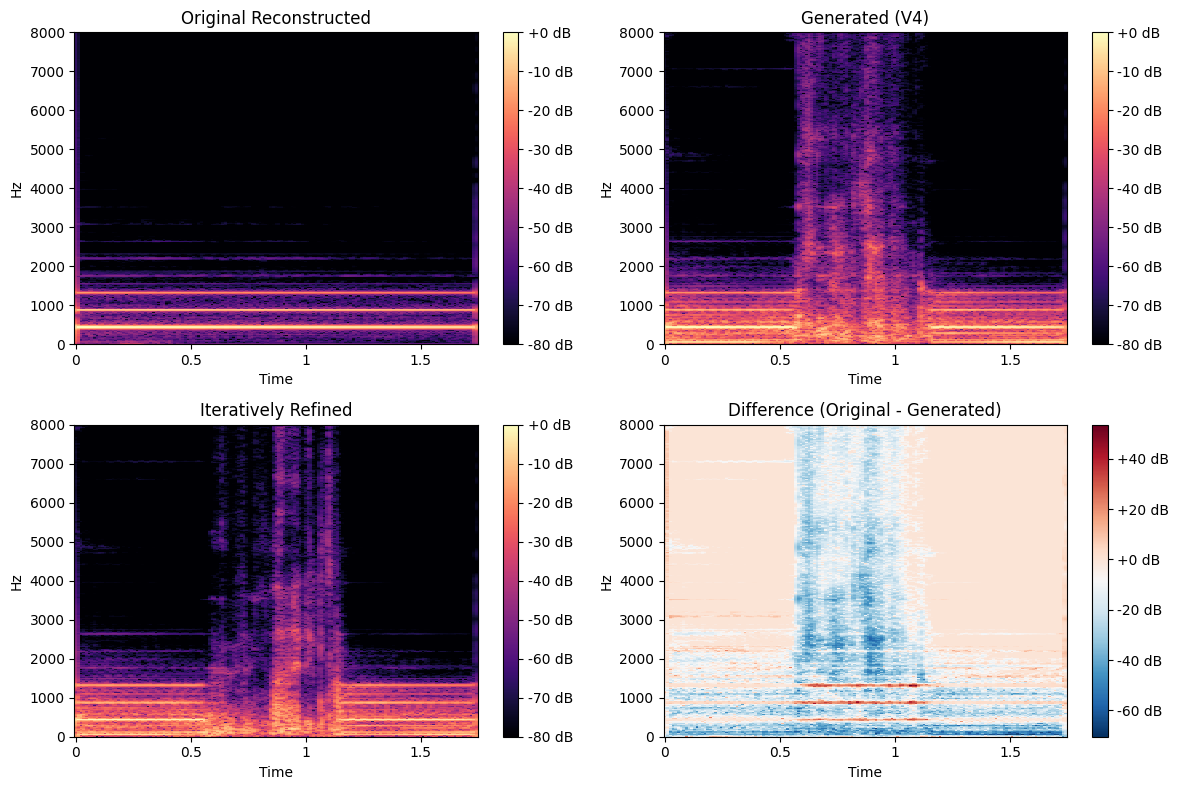


Masked region: 0.57s to 1.15s (marked with red lines in plots)


In [11]:
import librosa
import librosa.display

# Create spectrograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Original audio spectrogram
D_orig = librosa.stft(reconstructed)
db_orig = librosa.amplitude_to_db(np.abs(D_orig), ref=np.max)
img1 = librosa.display.specshow(db_orig, sr=44100, x_axis='time', y_axis='hz', ax=axes[0, 0])
axes[0, 0].set_title('Original Reconstructed')
axes[0, 0].set_ylim(0, 8000)

# Generated audio spectrogram
D_gen = librosa.stft(generated_audio)
db_gen = librosa.amplitude_to_db(np.abs(D_gen), ref=np.max)
img2 = librosa.display.specshow(db_gen, sr=44100, x_axis='time', y_axis='hz', ax=axes[0, 1])
axes[0, 1].set_title('Generated (V4)')
axes[0, 1].set_ylim(0, 8000)

# Iteratively refined spectrogram
D_ref = librosa.stft(refined_audio)
db_ref = librosa.amplitude_to_db(np.abs(D_ref), ref=np.max)
img3 = librosa.display.specshow(db_ref, sr=44100, x_axis='time', y_axis='hz', ax=axes[1, 0])
axes[1, 0].set_title('Iteratively Refined')
axes[1, 0].set_ylim(0, 8000)

# Difference spectrogram (original vs generated)
db_diff = db_orig - db_gen
img4 = librosa.display.specshow(db_diff, sr=44100, x_axis='time', y_axis='hz', ax=axes[1, 1], cmap='RdBu_r')
axes[1, 1].set_title('Difference (Original - Generated)')
axes[1, 1].set_ylim(0, 8000)

# Add colorbars
for i, img in enumerate([img1, img2, img3, img4]):
    fig.colorbar(img, ax=axes[i//2, i%2], format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Mark the masked region
time_start = mask_start * 768 / 44100
time_end = mask_end * 768 / 44100
print(f"\nMasked region: {time_start:.2f}s to {time_end:.2f}s (marked with red lines in plots)")

# Add vertical lines to mark masked region
for ax in axes.flat:
    ax.axvline(x=time_start, color='red', linestyle='--', alpha=0.5)
    ax.axvline(x=time_end, color='red', linestyle='--', alpha=0.5)

In [12]:
# Test different temperatures
temperatures = [0.8, 1.0, 1.2]
results = []
seq_len = 100  # Fixed sequence length

for temp in temperatures:
    # Generate coarse
    gen_coarse = generate_with_v4_model(
        tokens[:, :4, :],
        mask[:, :4, :],
        coarse_v4_session,
        temperature=temp,
        top_p=0.9
    )
    
    # Prepare C2F
    c2f_in = np.zeros((1, 14, seq_len), dtype=np.int64)
    c2f_in[:, :4, :] = gen_coarse
    
    # Generate C2F
    gen_c2f = generate_with_v4_model(
        c2f_in,
        c2f_mask,
        c2f_v4_session,
        temperature=temp * 0.8,  # Slightly lower for fine
        top_p=0.95
    )
    
    # Decode
    gen_audio = decode_tokens(gen_c2f)
    results.append((temp, gen_audio))
    
# Display results
for temp, gen_audio in results:
    print(f"\nTemperature {temp}:")
    ipd.display(ipd.Audio(gen_audio, rate=44100))


Temperature 0.8:



Temperature 1.0:



Temperature 1.2:


## Summary

The V4 models use the correct embedding architecture with `latent_dim=8`, matching the original VampNet implementation. This should significantly improve audio quality compared to the previous models that incorrectly used `d_model=1280` for embeddings.

Key improvements:
1. Correct embedding dimensions (8D instead of 1280D)
2. Proper weight transfer from pretrained VampNet
3. ONNX-compatible implementation that avoids conditional logic
4. Maintains sampling capabilities with temperature and top-p

**Important limitation**: The models are trained to work with exactly 100 tokens, which corresponds to ~1.74 seconds of audio at 44.1kHz. Longer audio must be processed in chunks or truncated.